In [5]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.express as px
import plotly.graph_objs as go
from sklearn import datasets
from dash.dependencies import Input, Output, State
import base64
import io
import zipfile
import pandas as pd

# Load dataset of handwritten digits
#digits = datasets.load_digits()
from PIL import Image
import numpy as np
import pandas as pd
import os
from PIL import Image, ImageFilter
from matplotlib import pyplot as plt

# Set path to directory containing folders of images
dir_path = "Number"

# Set image dimensions
height = 28
width = 28

# Load images into NumPy array
def imageprepare(argv):
    im = Image.open(argv).convert('L')
    width = float(im.size[0])
    height = float(im.size[1])
    newImage = Image.new('L', (28,28), (255))
    
    if width > height:
        nheight = int(round((20 / width*height), 0))
        if (nheight == 0):
            nheight = 1
        img = im.resize((20, nheight), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
        wtop = int(round(((28 - nheight) / 2), 0))
        newImage.paste(img, (4, wtop))
    else:
        nwidth = int(round((20 / width*height), 0))
        if (nwidth == 0):
            nwidth = 1
        img = im.resize((nwidth, 20), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
        wleft = int(round(((28 - nwidth) / 2), 0))
        newImage.paste(img, (wleft, 4))

    tv = list(newImage.getdata())
    
    tva = [(255 - x) * 1 / 255 for x in tv]
    #print(tva)
    return tva

image_data = []
for foldername in os.listdir(dir_path):
    folder_path = os.path.join(dir_path, foldername)
    if os.path.isdir(folder_path):
        for filename in os.listdir(folder_path):
            if filename.endswith(".png"):
                # Load image with Pillow
                image = [imageprepare(os.path.join(folder_path, filename))]

                # Append image array to list with label
                image_data.append((image, foldername))

# Convert list of image arrays to NumPy array
image_data = np.array(image_data)

#EDA

# Load digits dataset from sklearn
digits = pd.DataFrame(image_data, columns = ['data', 'target'])
digits.target = digits.target.astype('int')
#display(digits)
digits_df = pd.DataFrame({'Number': range(10), 'Frequency': [list(digits.target).count(str(i)) for i in range(10)]})

#Bar Plot
# Count the frequency of each digit in the dataset
digit_counts = np.bincount(digits.target)

# Create a bar chart with different x-axis colors for each number
data = [go.Bar(
            x=list(range(10)),
            y=digit_counts,
            marker=dict(
                color=['#FF5733', '#FFC300', '#DAF7A6', '#C70039', '#900C3F', '#581845', '#FDFD96', '#A9A9A9', '#48C9B0', '#1F618D']
            )
        )]

layout = go.Layout(
    title='Frequency of Digits in Dataset',
    xaxis=dict(title='Digit', tickmode='array', tickvals=list(digits_df['Number'])),
    yaxis=dict(title='Frequency')
)

fig = go.Figure(data=data, layout=layout)

#Pie
# Count frequency of digits
digit_counts = {str(i): list(digits.target).count(i) for i in range(10)}

# Sort count frequencies by number
sorted_counts = sorted(digit_counts.items(), key=lambda x: x[0], reverse=False)

# Create graph data
pie_graph_data = {
    'labels': [count[0] for count in sorted_counts],
    'values': [count[1] for count in sorted_counts],
    'sort': False
}
fig_p = {'data': [{'labels': pie_graph_data['labels'], 'values': pie_graph_data['values'], 'type': 'pie', 'sort': False}],
        'layout': {'title': 'Pie Graph'}}


# Create Dash app
app = dash.Dash(__name__)

# Define app layout
app.layout = html.Div(className="bg-white-200 items-center p-2",			
			children=[
				#-- table
				html.Div(className="grid grid-cols-1 rounded-md shadow p-6 rounded-lg bg-gray-50 items-center text-center ",
							children=[

								html.Table(children=[
									dcc.Upload(
                                        id='upload-data',
                                        children=html.Div([
                                            html.A('Select Zip File')
                                        ]),
                                        style={
                                            'width': '100%',
                                            'height': '60px',
                                            'lineHeight': '60px',
                                            'borderWidth': '1px',
                                            'borderStyle': 'dashed',
                                            'borderRadius': '5px',
                                            'textAlign': 'center',
                                            'margin': '10px'
                                        },
                                        multiple=False
                                    ),
                                    html.Div(id='output-data-upload'),
                                    
                                    ])
							
							
							]
					),
				
				html.Div(className='grid grid-cols-3 gap-4 p-4 items-center',
						# -- grid
						children=[							
							# -- box 1
							html.Div(className="rounded-md shadow p-6 rounded-lg bg-gray-50 p-1.5",
									children=[
										html.Div(className="text-lg font-bold",
											children='bar-graph'),
										dcc.Graph(
                                            id='bar-graph',
                                            figure= fig
                                        ) # -- end graph
									]
									),	
							# -- box 2
							html.Div(className="rounded-md shadow p-6 rounded-lg bg-gray-50 p-1.5",
									children=[
										html.Div(className="text-lg font-bold",
											children='pie-graph'),
										dcc.Graph(
                                            id='pie-graph',
                                            figure= fig_p
                                        )  # -- end graph
									]
									),
															
							]) # -- end of grid
				])

@app.callback(Output('output-data-upload', 'children'),
              Input('upload-data', 'contents'),
              State('upload-data', 'filename'))
def parse_contents(contents, filename):
    content_type, content_string = contents.split(',')

    print(content_string)

    zip_file = zipfile.ZipFile(io.BytesIO(base64.b64decode(content_string)))
    file_names = zip_file.namelist()
    print(file_names)

    # Extract zip file contents to a temporary directory
    temp_dir = 'temp/'
    zip_file.extractall(temp_dir)

    

    # Process the extracted images and return the result
    # Here you can add your machine learning code to process the images

    # Return the result as a string
    return html.Div([
        html.H5(filename),
        html.H5('Number of images: {}'.format(len(file_names))),
        html.P('Result: ...')
    ])
def update_output(contents, filename):
    if contents is not None:
        children = [
            parse_contents(contents, filename)
        ]
        return children

# Run app
if __name__ == '__main__':
    app.run_server()

C:\Users\tanat\AppData\Local\Temp\ipykernel_7844\1081435687.py:47: DeprecationWarning:

ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.



Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


C:\Users\tanat\AppData\Local\Temp\ipykernel_7844\1081435687.py:70: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [14/Jun/2023 07:15:29] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [14/Jun/2023 07:15:29] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [14/Jun/2023 07:15:29] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [14/Jun/2023 07:15:29] "GET /_dash-component-suites/dash/dcc/async-upload.js HTTP/1.1" 200 -
127.0.0.1 - - [14/Jun/2023 07:15:29] "GET /_dash-component-suites/dash/dcc/async-graph.js HTTP/1.1" 200 -
[2023-06-14 07:15:29,465] ERROR in app: Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "c:\Users\tanat\anaconda3\lib\site-packages\flask\app.py

UEsDBBQAAAAAANqty1YAAAAAAAAAAAAAAAAJAAAATnVtYmVyLzAvUEsDBBQAAAAIAJFTy1bNwlDl8gAAAPMAAAARAAAATnVtYmVyLzAvMF8wMS5wbmfrDPBz5+WS4mJgYOD19HAJAtIyIMzBBCT/5nscBlIs6Y6+jgwMG/u5/ySyAvmcBR6RxQwMQiUgzHgvTb4CKDjV08UxxMP77ZSLXA0GHK5b//9/rmqRciF0e4zAlUrNjO8+p4+tNb119uL66J9Lf//cUVL5Y+bO+4KVNz2snrmbLPJPvDOVTfJwdPP9lz2BH8QYXi4xZAiPMuRaOvHSvHUhz0W+hUx1eue99x6rDi+Tl42iw6y6XyXPCpYKfejy7XX69/420201M66TmqbXZu/qebo4v2362cwDzEGLhJM3eUudCHqzDehABk9XP5d1TglNAFBLAwQUAAAACACRU8tWYJAsX+cAAADoAAAAEQAAAE51bWJlci8wLzBfMDIucG5n6wzwc+flkuJiYGDg9fRwCQLSMiDMwQQk/+Z7HAZSLOmOvo4MDBv7uf8ksgL5nAUekcUMDEIlIMx4L02+AijY5eniGOLh/XaSI98BBQ6Wpf//b1Y9OGGZXoKIreV0My7ltd5br006e3neyphMu+glzhOVFn37djCTZ8mq16dTuLdVz1+fu0FYj2vZFUmXh7E/0vd41i5mnvbp52W3NO8lDSWFPs+uLHk9Z1LUy98HTcMk9wmv3LbOOzbN8cZJD9/9SYLL0+8sXeMmVFQ86zxbpqZ+5xsPKb347aeBrmLwdPVzWeeU0AQAUEsDBBQAAAAIAJJTy1Y9N0/Q/QAAAP8AAAARAAAATnVtYmVyLzAvMF8wMy5wbmfrDPBz5+WS4mJgYOD19HAJAtIyIMzBBCT/5nscBlIs6Y6+jgwMG/u5/ySyAvmcBR6RxQwMQiUgzHgvTb4CKLjQ08UxxMP77ZSLXA0KPK5b//9Pl9ZtO2O9PNnR8fnSot3L

127.0.0.1 - - [14/Jun/2023 07:15:37] "POST /_dash-update-component HTTP/1.1" 200 -


In [1]:
from PIL import Image
import numpy as np
import os

# Set path to directory containing folders of images
dir_path = "Number"

# Set image dimensions
height = 28
width = 28

# Load images into NumPy array
image_data = []
for foldername in os.listdir(dir_path):
    folder_path = os.path.join(dir_path, foldername)
    if os.path.isdir(folder_path):
        for filename in os.listdir(folder_path):
            if filename.endswith(".png"):
                # Load image with Pillow
                image = Image.open(os.path.join(folder_path, filename))

                # Convert image to grayscale
                image = image.convert("L")

                # Resize image to desired dimensions
                image = image.resize((width, height))

                # Convert image to NumPy array
                image_array = np.asarray(image)

                # Append image array to list with label
                image_data.append((image_array, foldername))

# Convert list of image arrays to NumPy array
image_data = np.array(image_data)

print(image_data.shape)

display(image_data[240, 1])
display(image_data[240, 0])

(400, 2)


C:\Users\tanat\AppData\Local\Temp\ipykernel_7844\3633069420.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  image_data = np.array(image_data)


'6'

array([[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255],
       [25

6


<function matplotlib.pyplot.show(close=None, block=None)>

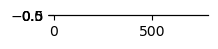

In [66]:
import matplotlib.pyplot as plt

# Display image
img = image_data[240][0]
print(image_data[240][1])
plt.figure(figsize = (2, 2))
plt.imshow(img, cmap = plt.cm.gray)
plt.show

In [63]:
image_data[240][1]

'6'

In [8]:
from PIL import Image
import numpy as np
import pandas as pd
import os
from PIL import Image, ImageFilter
from matplotlib import pyplot as plt

# Set path to directory containing folders of images
dir_path = "Number"

# Set image dimensions
height = 28
width = 28

# Load images into NumPy array
def imageprepare(argv):
    im = Image.open(argv).convert('L')
    width = float(im.size[0])
    height = float(im.size[1])
    newImage = Image.new('L', (28,28), (255))
    
    if width > height:
        nheight = int(round((20 / width*height), 0))
        if (nheight == 0):
            nheight = 1
        img = im.resize((20, nheight), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
        wtop = int(round(((28 - nheight) / 2), 0))
        newImage.paste(img, (4, wtop))
    else:
        nwidth = int(round((20 / width*height), 0))
        if (nwidth == 0):
            nwidth = 1
        img = im.resize((nwidth, 20), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
        wleft = int(round(((28 - nwidth) / 2), 0))
        newImage.paste(img, (wleft, 4))

    tv = list(newImage.getdata())
    
    tva = [(255 - x) * 1 / 255 for x in tv]
    #print(tva)
    return tva

image_data = []
for foldername in os.listdir(dir_path):
    folder_path = os.path.join(dir_path, foldername)
    if os.path.isdir(folder_path):
        for filename in os.listdir(folder_path):
            if filename.endswith(".png"):
                # Load image with Pillow
                image = [imageprepare(os.path.join(folder_path, filename))]

                # Append image array to list with label
                image_data.append((image, foldername))

# Convert list of image arrays to NumPy array
image_data = np.array(image_data)
image_df = pd.DataFrame(image_data, columns = ['data', 'target'])
image_df.target = image_df.target.astype('int')
digits_df = pd.DataFrame({'Number': range(10), 'Frequency': [list(image_df.target).count(i) for i in range(10)]})
digits_df

C:\Users\tanat\AppData\Local\Temp\ipykernel_18528\2216891113.py:33: DeprecationWarning:

ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.

C:\Users\tanat\AppData\Local\Temp\ipykernel_18528\2216891113.py:56: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



,Number,Frequency
0,0,40
1,1,40
2,2,40
3,3,40
4,4,40
5,5,40
6,6,40
7,7,40
8,8,40
9,9,40


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.01568627450980392
0.011764705882352941
0.0
0.0
0.0
0.0
0.03137254901960784
0.0
0.0
0.0
0.0
0.01568627450980392
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.02745

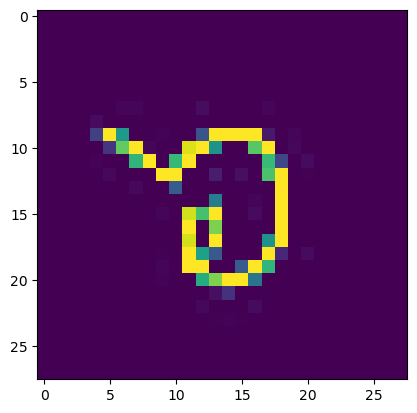

In [31]:
newArr=[[0 for d in range(28)] for y in range(28)]
k=0
for i in range(28):
    for j in range(28):
        newArr[i][j]=img[0][k]
        k=k+1
        
for i in range(28):
    for j in range(28):
        print(newArr[i][j])
    print('\n')
    
plt.imshow(newArr, interpolation='nearest')
plt.show()



In [22]:
from PIL import Image, ImageFilter
from matplotlib import pyplot as plt

def imageprepare(argv):
    im = Image.open(argv).convert('L')
    width = float(im.size[0])
    height = float(im.size[1])
    newImage = Image.new('L', (28,28), (255))
    
    if width > height:
        nheight = int(round((20 / width*height), 0))
        if (nheight == 0):
            nheight = 1
        img = im.resize((20, nheight), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
        wtop = int(round(((28 - nheight) / 2), 0))
        newImage.paste(img, (4, wtop))
    else:
        nwidth = int(round((20 / width*height), 0))
        if (nwidth == 0):
            nwidth = 1
        img = im.resize((nwidth, 20), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
        wleft = int(round(((28 - nwidth) / 2), 0))
        newImage.paste(img, (wleft, 4))

    tv = list(newImage.getdata())
    
    tva = [(255 - x) * 1 / 255 for x in tv]
    print(tva)
    return tva

In [1]:
import os
import base64
import io
import numpy as np
import pandas as pd
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
from PIL import Image, ImageFilter
import plotly.graph_objs as go

# Set image dimensions
dir_path = "Number" #Default
height = 28
width = 28

# Load images into NumPy array
def imageprepare(argv):
    im = Image.open(argv).convert('L')
    width = float(im.size[0])
    height = float(im.size[1])
    newImage = Image.new('L', (28,28), (255))
    
    if width > height:
        nheight = int(round((20 / width*height), 0))
        if (nheight == 0):
            nheight = 1
        img = im.resize((20, nheight), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
        wtop = int(round(((28 - nheight) / 2), 0))
        newImage.paste(img, (4, wtop))
    else:
        nwidth = int(round((20 / width*height), 0))
        if (nwidth == 0):
            nwidth = 1
        img = im.resize((nwidth, 20), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
        wleft = int(round(((28 - nwidth) / 2), 0))
        newImage.paste(img, (wleft, 4))

    tv = list(newImage.getdata())
    
    tva = [(255 - x) * 1 / 255 for x in tv]
    #print(tva)
    return tva
    
#defalut
dir_path = "Number"
image_data = []
for foldername in os.listdir(dir_path):
    folder_path = os.path.join(dir_path, foldername)
    if os.path.isdir(folder_path):
        for filename in os.listdir(folder_path):
            if filename.endswith(".png"):
                # Load image with Pillow
                image = [imageprepare(os.path.join(folder_path, filename))]

                # Append image array to list with label
                image_data.append((image, foldername))

# Convert list of image arrays to NumPy array
image_data = np.array(image_data)

# Define Dash app
app = dash.Dash(__name__)

# Define layout
app.layout = html.Div([
    dcc.Upload(
        id='upload-data',
        children=html.Div([
            'Drag and drop or click to select files'
        ]),
        style={
            'width': '100%',
            'height': '60px',
            'lineHeight': '60px',
            'borderWidth': '1px',
            'borderStyle': 'dashed',
            'borderRadius': '5px',
            'textAlign': 'center',
            'margin': '10px'
        },
        multiple=True
    ),
    html.Div(id='output-data'),
    dcc.Graph(id='digit-counts')
])

# Define callback to preprocess uploaded files
@app.callback(Output('output-data-upload', 'children'),
              Input('upload-data', 'contents'),
              State('upload-data', 'filename'))
def preprocess_images(contents, filename):
    content_type, content_string = contents.split(',')
    zip_file = zipfile.ZipFile(io.BytesIO(base64.b64decode(content_string)))
    file_names = zip_file.namelist()
    print(file_names)
    # Extract zip file contents to a temporary directory
    temp_dir = 'temp/'
    zip_file.extractall(temp_dir)    

    if contents is not None:
        # Decode and preprocess images
        images = []
        for content in contents:
            content_type, content_string = content.split(',')
            decoded = base64.b64decode(content_string)
            image = Image.open(io.BytesIO(decoded))
            image_array = np.array([imageprepare(image)])
            images.append(image_array)
        # Convert list of image arrays to NumPy array
        image_data = np.concatenate(images)
        # Load digits dataset from NumPy array
        digits = pd.DataFrame(image_data, columns = ['data'])
        # Extract digit labels from filenames
        filenames = [content.split(',')[1].split(';')[0].split('=')[1] for content in contents]
        digits['target'] = [int(os.path.splitext(filename)[0]) for filename in filenames]
        # Return data summary
        return html.Div([
            html.H4('Preprocessed Data Summary'),
            html.P('Number of images: {}'.format(len(image_data))),
            html.P('Image dimensions: {}x{}'.format(height, width)),
            html.P('Number of digits: {}'.format(len(digits))),
            html.P('Number of unique digits: {}'.format(len(digits['target'].unique()))),
        ])

# Define callback to display digit frequency
@app.callback(Output('digit-counts', 'figure'),
              Input('output-data', 'children'))
def display_digit_counts(summary):
    if summary is not None:
        # Count the frequency of each digit in the dataset
        digit_counts = np.bincount(digits['target'])
        # Create a bar chart with different x-axis colors for each number
        data = [go.Bar(
            x=list(range(10)),
            y=digit_counts,
            marker=dict(
                color=['#FF5733', '#FFC300', '#DAF7A6', '#C70039', '#900C3F', '#581845', '#FDFD96', '#A9A9A9', '#48C9B0', '#1F618D']))]
        layout = go.Layout(
            title='Frequency of Digits in Dataset',
            xaxis=dict(title='Digit', tickmode='array', tickvals=list(range(10))),
            yaxis=dict(title='Frequency'))
        fig = go.Figure(data=data, layout=layout)
        return fig

# Run app
if __name__ == '__main__':
    app.run_server()

C:\Users\tanat\AppData\Local\Temp\ipykernel_17784\307418977.py:7: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
C:\Users\tanat\AppData\Local\Temp\ipykernel_17784\307418977.py:8: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
C:\Users\tanat\AppData\Local\Temp\ipykernel_17784\307418977.py:36: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = im.resize((nwidth, 20), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
C:\Users\tanat\AppData\Local\Temp\ipykernel_17784\307418977.py:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is dep

NameError: name 'State' is not defined

In [ ]:
@app.callback(Output('output-data-upload', 'children'),
              Input('upload-data', 'contents'),
              State('upload-data', 'filename'))
def parse_contents(contents, filename):
    content_type, content_string = contents.split(',')

    zip_file = zipfile.ZipFile(io.BytesIO(base64.b64decode(content_string)))
    file_names = zip_file.namelist()
    print(file_names)

    # Extract zip file contents to a temporary directory
    temp_dir = 'temp/'
    zip_file.extractall(temp_dir)

    

    # Process the extracted images and return the result
    # Here you can add your machine learning code to process the images

    # Return the result as a string
    return html.Div([
        html.H5(filename),
        html.H5('Number of images: {}'.format(len(file_names))),
        html.P('Result: ...')
    ])
def update_output(contents, filename):
    if contents is not None:
        children = [
            parse_contents(contents, filename)
        ]
        return children